Data - Loan predicting data

### Steps-
    1. Getting Libraries and data
    2. exploratory data analysis
    3. Filing the Missing values
    4. preprocessoring - hot encoding 
    5. Random forrest model building
    6. Tunning the parameters

### 1. Getting Libraries and data

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Reading the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df = pd.concat([train,test])
df.head(5)

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Property_Area,Self_Employed
0,5849,0.0,1.0,0,Graduate,Male,NaN,360.0,LP001002,Y,No,Urban,No
1,4583,1508.0,1.0,1,Graduate,Male,128.0,360.0,LP001003,N,Yes,Rural,No
2,3000,0.0,1.0,0,Graduate,Male,66.0,360.0,LP001005,Y,Yes,Urban,Yes
3,2583,2358.0,1.0,0,Not Graduate,Male,120.0,360.0,LP001006,Y,Yes,Urban,No
4,6000,0.0,1.0,0,Graduate,Male,141.0,360.0,LP001008,Y,No,Urban,No


In [3]:
df = df[['ApplicantIncome', 'CoapplicantIncome', 'Dependents','Education', 'Gender', 'LoanAmount', 'Loan_Amount_Term','Married', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status']]
df.head(5)

,ApplicantIncome,CoapplicantIncome,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Married,Self_Employed,Credit_History,Property_Area,Loan_Status
0,5849,0.0,0,Graduate,Male,NaN,360.0,No,No,1.0,Urban,Y
1,4583,1508.0,1,Graduate,Male,128.0,360.0,Yes,No,1.0,Rural,N
2,3000,0.0,0,Graduate,Male,66.0,360.0,Yes,Yes,1.0,Urban,Y
3,2583,2358.0,0,Not Graduate,Male,120.0,360.0,Yes,No,1.0,Urban,Y
4,6000,0.0,0,Graduate,Male,141.0,360.0,No,No,1.0,Urban,Y


### 2. exploratory data analysis

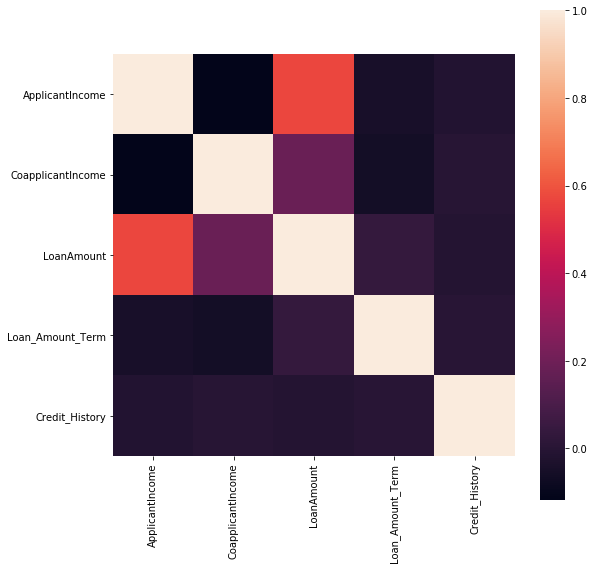

In [4]:
corr = train.select_dtypes(include = ['float64', 'int64']).corr()
plt.figure(figsize=(9, 9))
sns.heatmap(corr, vmax=1, square=True)
plt.show()

There is a correlation 'Applicatant income' and 'loan amount'. Also in 'Co Applicatant income' and 'loan amount'

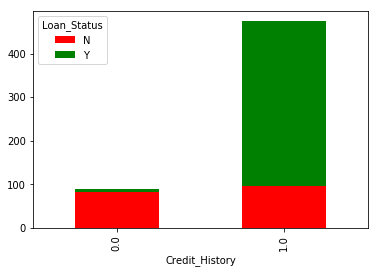

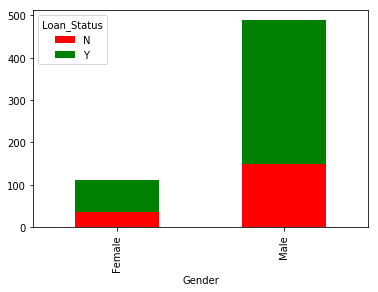

In [5]:
#combining the above 2 plots in a stacked chart
stack_chart = pd.crosstab(df['Credit_History'], df['Loan_Status'])
stack_chart.plot(kind='bar', stacked=True, color=['red','green'], grid=False)
stack_chart = pd.crosstab(df['Gender'], df['Loan_Status'])
stack_chart.plot(kind='bar', stacked=True, color=['red','green'], grid=False)

Credit historty graph clearly shows that people ,who did not give back loan in history , are not reliable.
There is no correlation loan status and gender

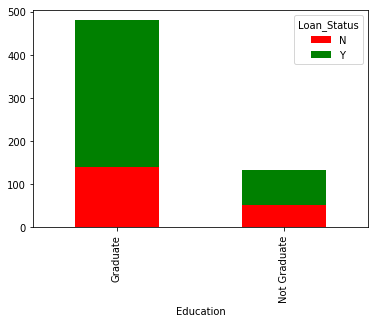

In [6]:
stack_chart = pd.crosstab(df['Education'], df['Loan_Status'])
stack_chart.plot(kind='bar', stacked=True, color=['red','green'], grid=False)



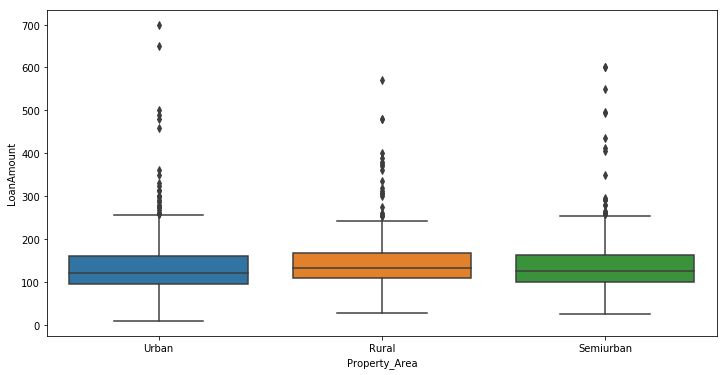

In [7]:
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Property_Area', y = 'LoanAmount',  data = df)

### 3. Filing the Missing values

ApplicantIncome        0
CoapplicantIncome      0
Dependents            25
Education              0
Gender                24
LoanAmount            27
Loan_Amount_Term      20
Married                3
Self_Employed         55
Credit_History        79
Property_Area          0
Loan_Status          367
dtype: int64

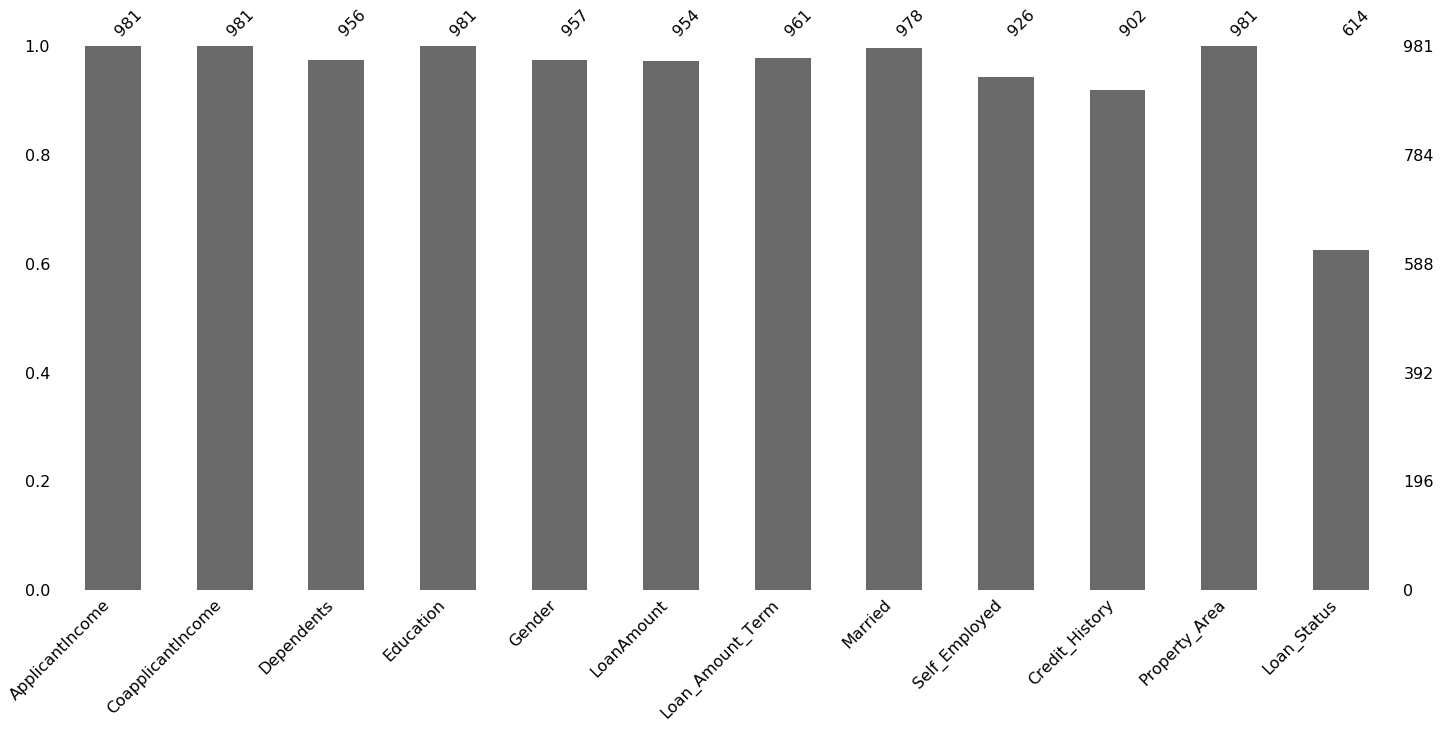

In [8]:
msno.bar(df)
df.apply(lambda x:sum(x.isnull()),axis=0)

In [9]:
replace_dict = {'0':'0', '1':'1', '2':'2', '3+':'3'}

df.Dependents = df.Dependents.replace(replace_dict)

df.Dependents = df.Dependents.fillna('Unknown')

In [10]:
df.Gender.value_counts()

Male      775
Female    182
Name: Gender, dtype: int64

males are around ~81%, so we'll fill the missing values with "male"

In [11]:
df.Gender = df.Gender.fillna('Male')

In [12]:
df.LoanAmount = df.LoanAmount.fillna(df.LoanAmount.mean())

In [13]:
df['Loan_Amount_Term'].value_counts()

360.0    823
180.0     66
480.0     23
300.0     20
240.0      8
84.0       7
120.0      4
36.0       3
60.0       3
12.0       2
350.0      1
6.0        1
Name: Loan_Amount_Term, dtype: int64

In [14]:
df.Loan_Amount_Term = df.Loan_Amount_Term.fillna(360.0)

In [15]:
#filling the 3 missing values with yes
df.Married = df.Married.fillna('Yes')

In [16]:
df['Self_Employed'].value_counts()

No     807
Yes    119
Name: Self_Employed, dtype: int64

In [17]:
df.Self_Employed = df.Self_Employed.fillna('No')

In [18]:
df.Credit_History = df.Credit_History.fillna('1.0')

In [19]:
replace_dict = {1.0:'Yes', 0.0:'No'}
df.Credit_History = df.Credit_History.replace(replace_dict)
df.Credit_History = df.Credit_History.fillna('Unknown')

In [20]:
df.Loan_Status.value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

68.7%

In [21]:
df.Loan_Status = df.Loan_Status.fillna('Y')

### 4. preprocessoring - hot encoding 

In [22]:
X = df.iloc[:,0:11]
y=df.iloc[:,11]

In [23]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [24]:
from sklearn.preprocessing import LabelEncoder
cat_col = ['Credit_History',
           'Dependents',
           'Education',
           'Gender',
           'Married',
           'Property_Area',
           'Self_Employed']

le = LabelEncoder()  #Encode labels with value between 0 and n_classes-1.
for i in cat_col:
    X_train[i] = le.fit_transform(X_train[i]) #Fit label encoder and return encoded labels
X_train.dtypes

ApplicantIncome        int64
CoapplicantIncome    float64
Dependents             int64
Education              int64
Gender                 int64
LoanAmount           float64
Loan_Amount_Term     float64
Married                int64
Self_Employed          int64
Credit_History         int64
Property_Area          int64
dtype: object

In [25]:
for i in cat_col:
    X_test[i] = le.fit_transform(X_test[i]) #Fit label encoder and return encoded labels
X_test.dtypes

ApplicantIncome        int64
CoapplicantIncome    float64
Dependents             int64
Education              int64
Gender                 int64
LoanAmount           float64
Loan_Amount_Term     float64
Married                int64
Self_Employed          int64
Credit_History         int64
Property_Area          int64
dtype: object

### 5. Random forrest model building

In [26]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
predictions = rfc.predict(X_test)

In [28]:
from sklearn import metrics
metrics.accuracy_score(predictions, y_test)*100

75.2542372881356

### 6. Tunning the parameters

In [29]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [32]:
from sklearn.model_selection import GridSearchCV

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [33]:
CV_rfc.best_score_

0.8104956268221575

In [34]:
CV_rfc.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [39]:
rfc1=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [40]:
rfc1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [41]:
pred=rfc1.predict(X_test)

In [42]:
metrics.accuracy_score(pred, y_test)*100

80.67796610169492

So after tune the parameter of random forest ,we improve the accuracy from 75.25% to 80.67%